# Computing Reduced Density Matrices

$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

As explained in notebooks: *03_Using_PH_Class.ipynb* and *06_ParentHamiltonian_with_MPS.ipynb* the main operation needed for computing a **PH** from an ansatz is the calculation of density matrices. In this notebook, we explain how to compute them when the **MPS** representation is given.

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.INFO
    #level=logging.DEBUG
)
logger = logging.getLogger('__name__')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import sys
sys.path.append("../../")

In [ ]:
from PH.qpu.select_qpu import select_qpu
# List with the strings that should be provided for an ideal QPU
ideal_qpus = ["c", "python", "linalg", "mps", "qlmass_linalg", "qlmass_mps"]
qpu_config = {
    "qpu_type": ideal_qpus[0], 
}
qpu = select_qpu(qpu_config)

## 1. Density Matrices

In a **MPS** representation the density matrix can be depicted as follow:

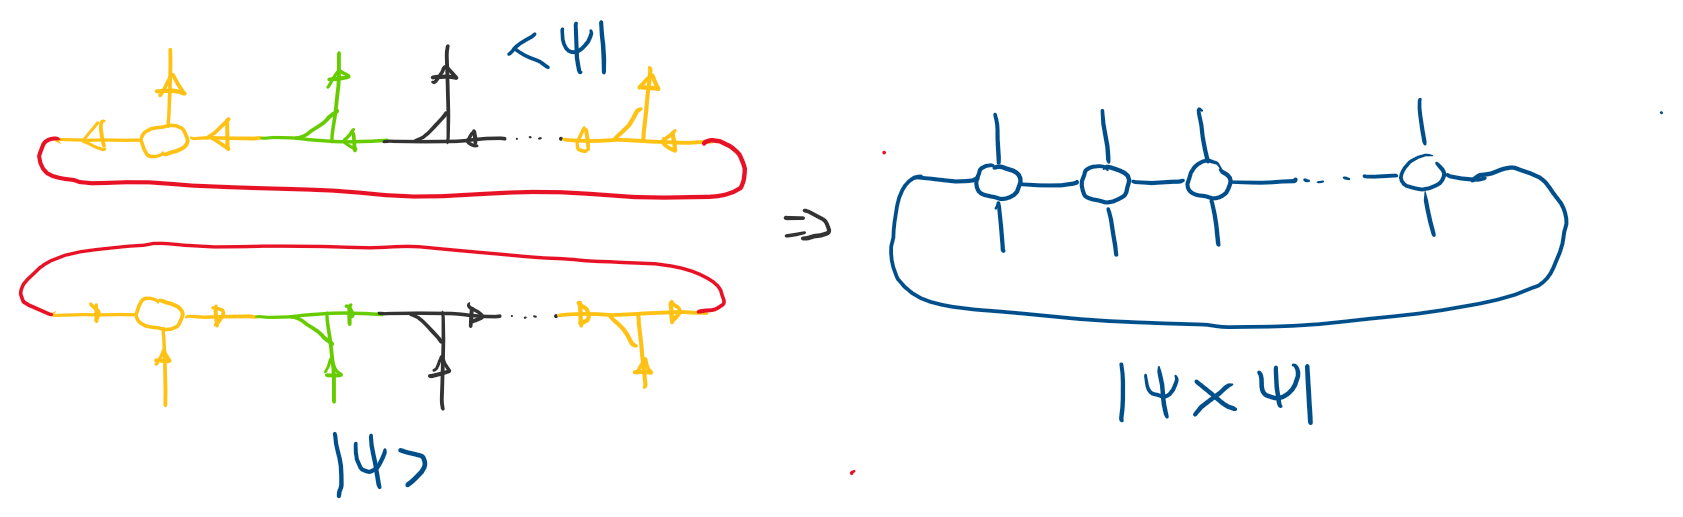

## 2. Reduced density matrices

The main computation needed for the **PH** is given the state:

$$\ket{\Psi} = \Psi_{i_0 i_1 \cdots i_{n-1}} \ket{i_0 i_1 \cdots i_{n-1}}$$

compute the reduced density matrix for $m$ consecutive qubits from a fixed qubit $i_k$

$$\rho_{k}^m = \text{Tr}_{i_l \notin \{i_{k}, i_{k+1}, \cdots, i_{k+m}\}} (\rho)  = 
    \rho_{i_{k} i_{k+1} \cdots i_{k+m}}^{j_{k} j_{k+1} \cdots j_{k+m}} = \\
    =\Psi_{\color{red}{i_0i_1} \cdots i_{k} i_{k+1} \cdots i_{k+m} \color{red}{i_{k+m+1} \cdots i_{n-1}}}
    \Psi^{*\;\color{red}{i_0i_1}\cdots j_{k} j_{k+1} \cdots j_{k+m} \color{red}{i_{k+m+1} \cdots i_{n-1}}}$$
    
In **MPS**^this reduced matrices can be depicted as follows:

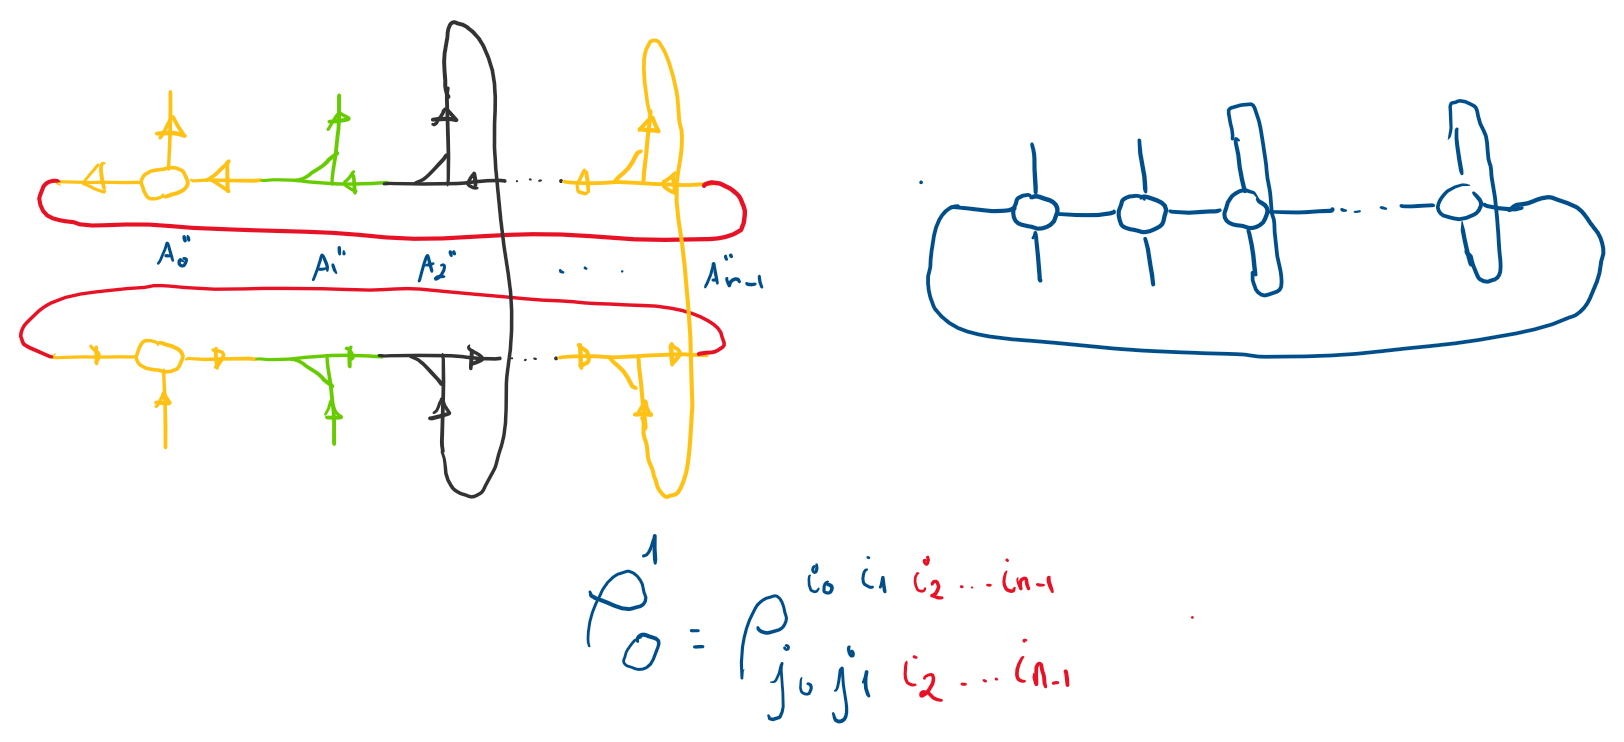


As can be seen, there are 2 types of indices in this computation: the **free indices** and the **contracted indices**.

### 2.1 Free Indices

Two consecutive tensors with free indices should be processed as show in the following figure:

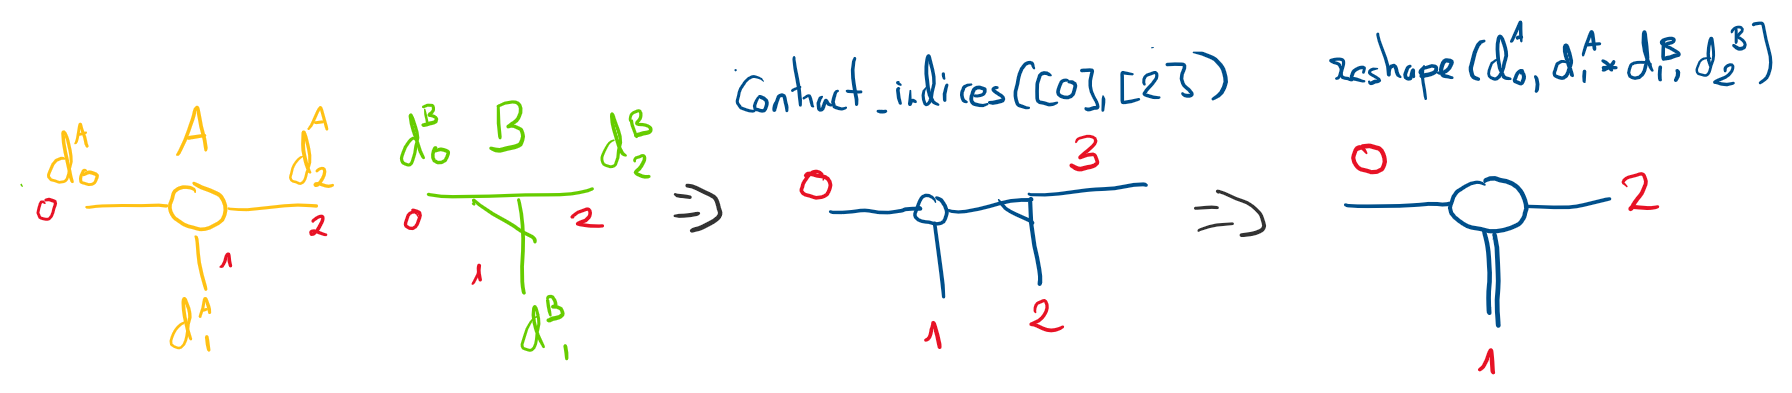

### 2.2 Contracted indices

The rank 3 tensor that must be contracted (with its conjuagate complex) should be processed as folows:

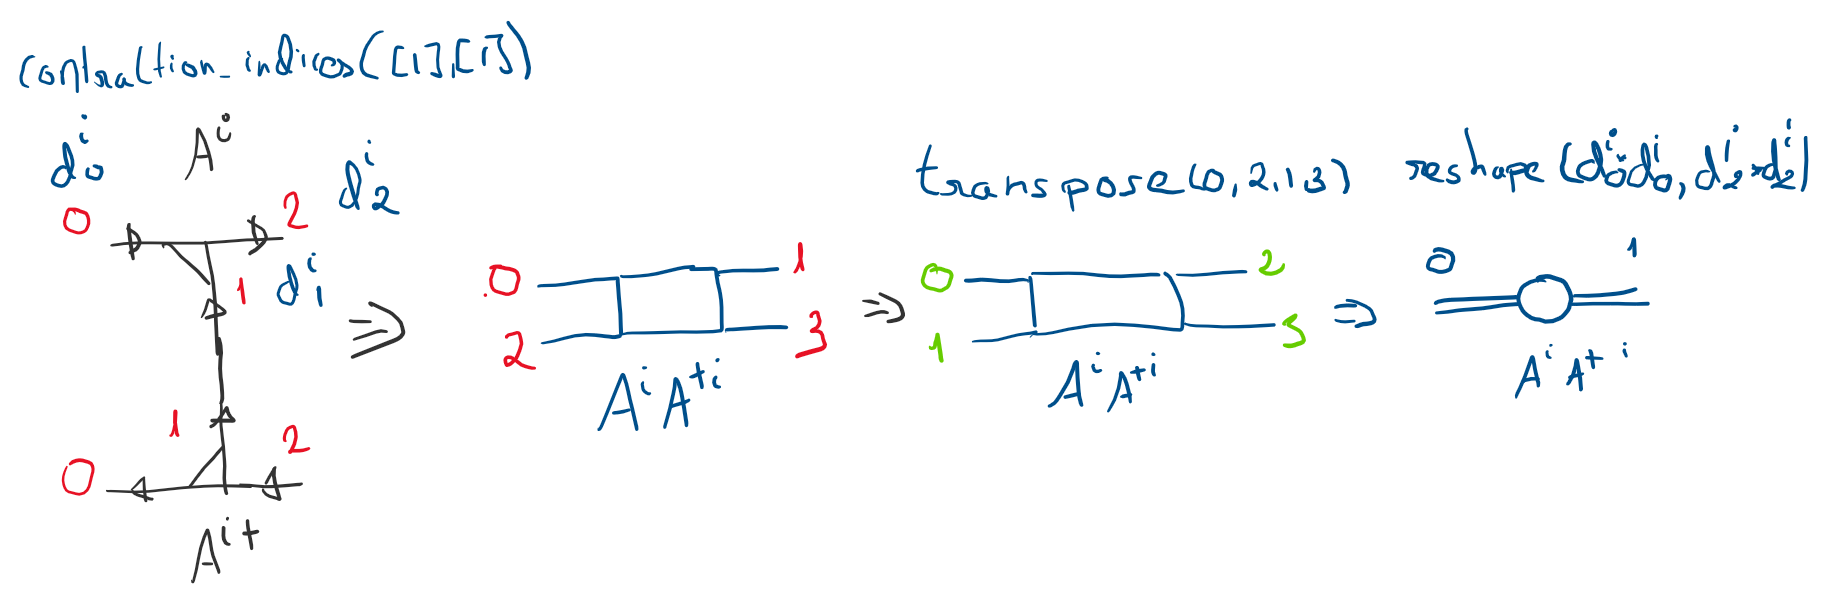

This operation can be done by the *contraction_physical_legs* from **mps** package

Once the contracted tensors are processed then the contraction of 2 consecutive ones is straighttoforward:

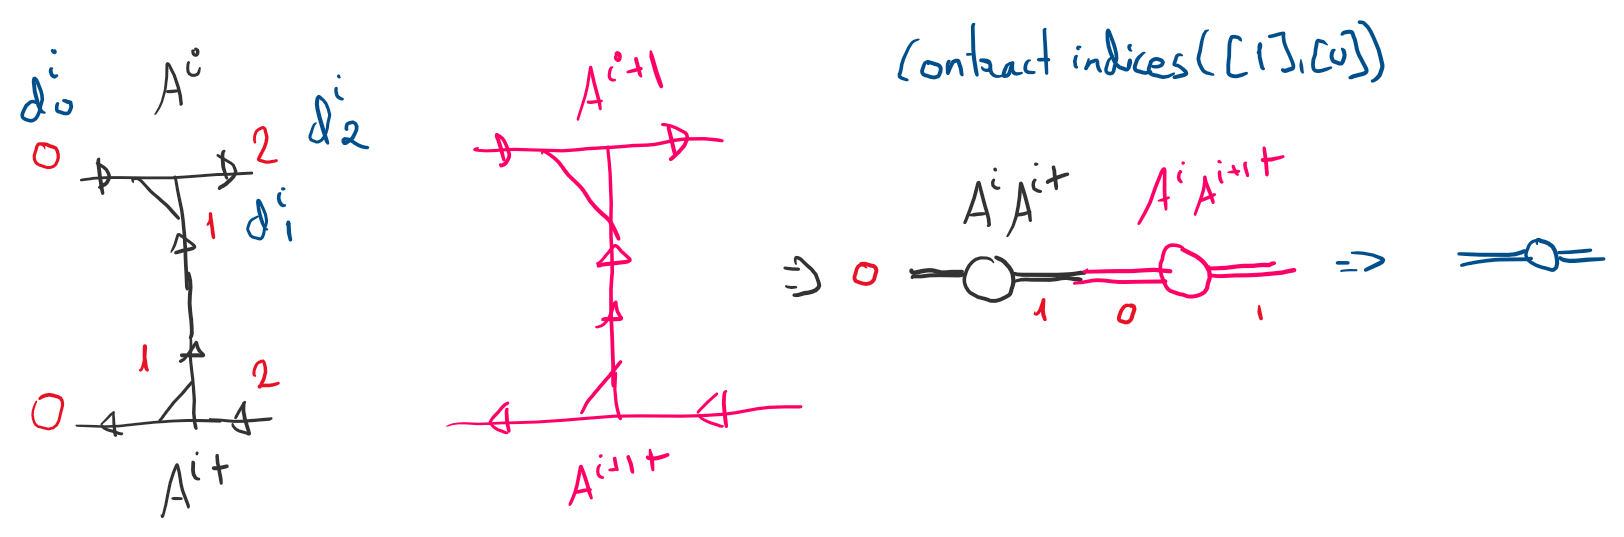

### 2.3 Final Contractions

Once all the **free** and the **contracted** rank 3 tensor have bee processed the final contraction should be done:

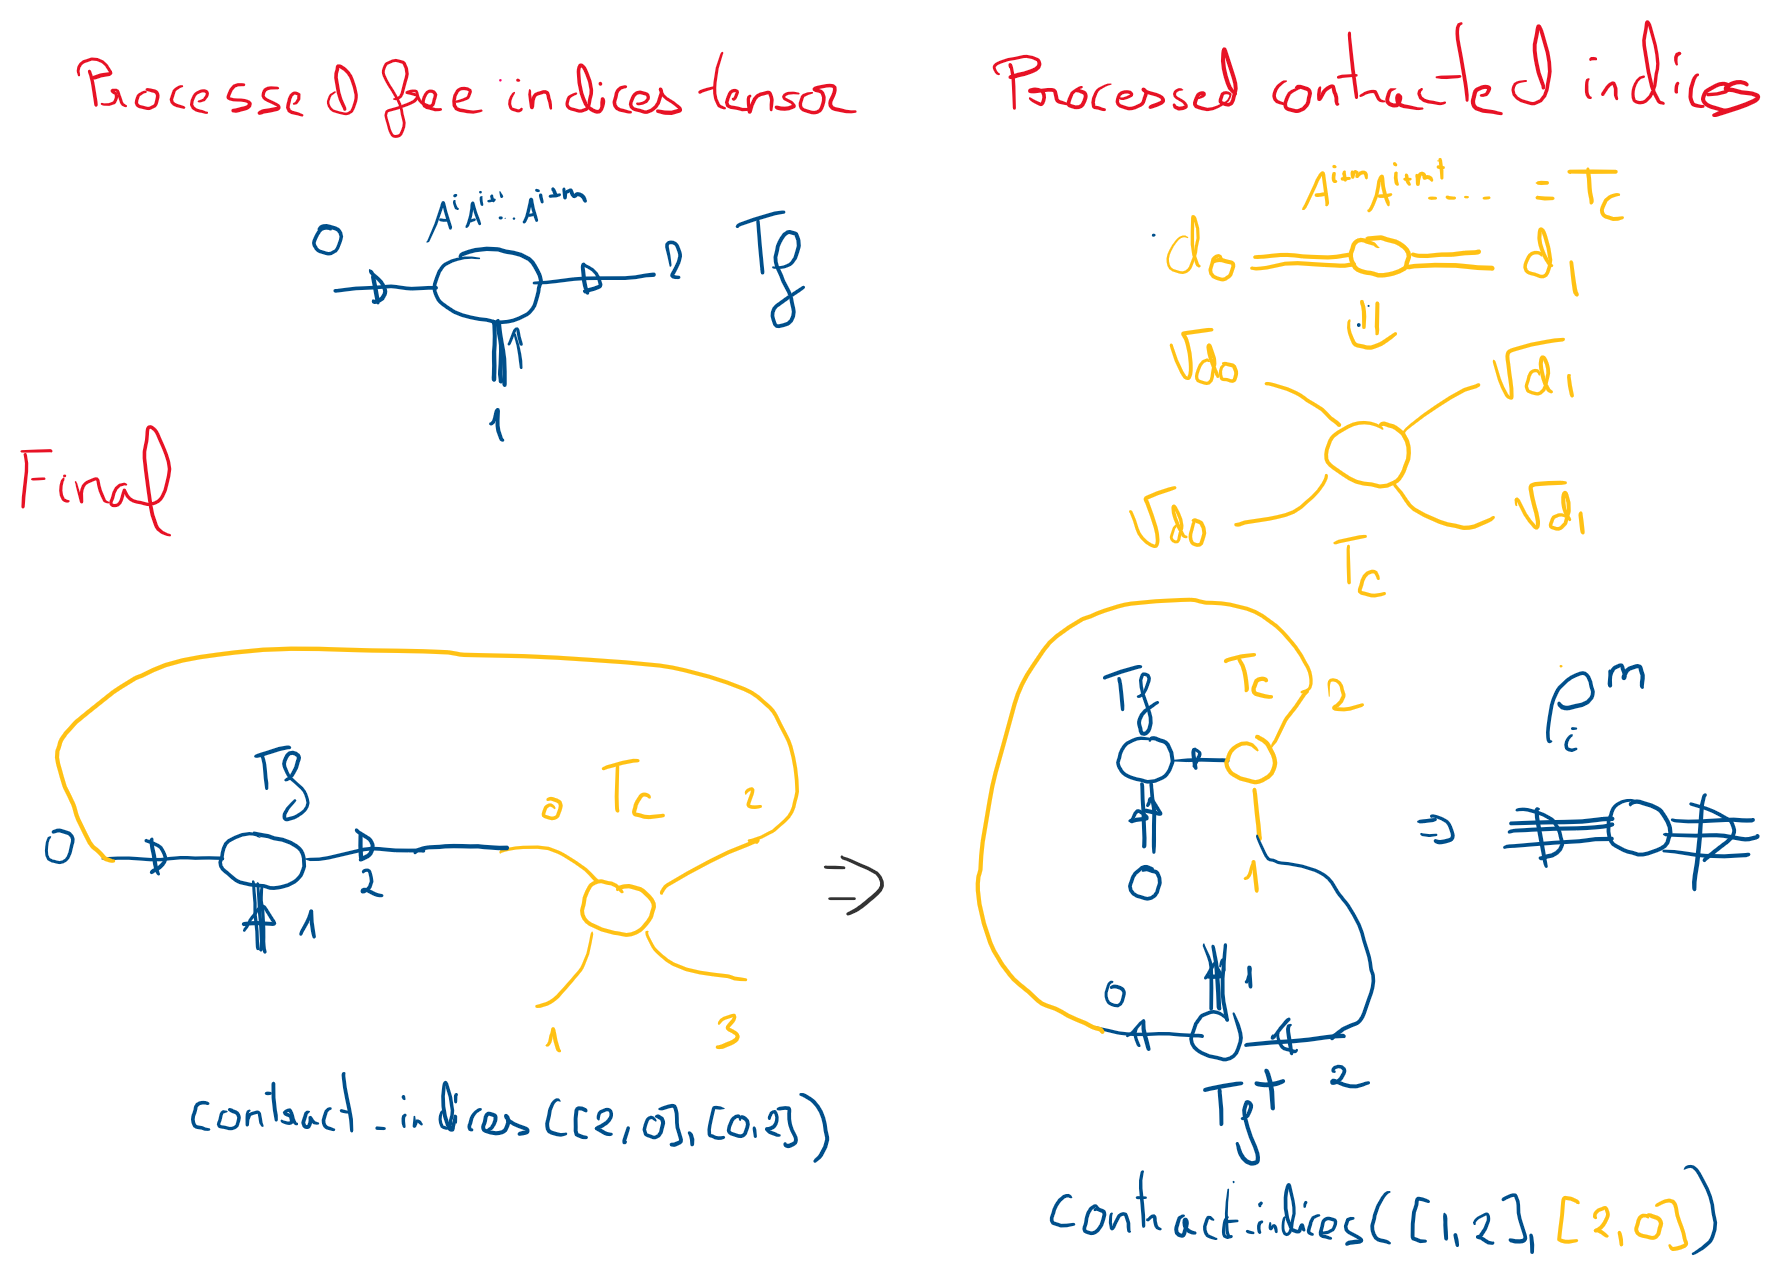

### 2.4 reduced_rho_mps

For doing all this computations the *reduced_rho_mps* from **PH.mps.parent_hamiltonian_mps** package allows to compute the reduced density matrices from a **MPS** by executing the scheme depicted before.

In [ ]:
# First we created the MPS from the ansatz

from PH.mps.ansatz_mps import ansatz_mps, get_angles
from PH.mps.mps import compose_mps, contract_indices_one_tensor
truncate = True
t_v = None
nqubits = 8
depth = 4
angles = get_angles(depth)
mps = ansatz_mps(nqubits, depth, angles, truncate, t_v)
tensor = compose_mps(mps)
# We create the state for comparison purpouses
state = contract_indices_one_tensor(tensor, [(0, tensor.ndim-1)])

In [ ]:
from PH.mps.parent_hamiltonian_mps import reduced_rho_mps
from PH.parent_hamiltonian.contractions import reduced_matrix

In [ ]:
free_indices = [5, 6, 7]
# indices for tracing put
contract_indices = [(free_indices[-1] + 1 + i) % len(mps) \
    for i in range(len(mps))]
contract_indices = list(
    filter(lambda x: x not in free_indices, contract_indices))
print(free_indices, contract_indices)

In [ ]:
# Reduced density matrix computations using MPS
my_red_rho_mps = reduced_rho_mps(mps, free_indices, contract_indices)
# Reduced density matrix computations using the pure state
my_red_rho_state = reduced_matrix(state, free_indices, contract_indices)

In [ ]:
# Testing both implementations
np.isclose(my_red_rho_mps, my_red_rho_state).all()